In [29]:
import pandas as pd
import numpy as np
import os
import itertools
import statistics
import math
%matplotlib inline

# global variables
cwd = os.getcwd()
out_csv_dir = "/mnt/EC86AD3086ACFC68/cnc/cars/output/csvs/"

In [30]:
# input variables
peaje = "Koran"

In [31]:
peaje = peaje+"/"
route = out_csv_dir+peaje
csv_dir = [csv for csv in os.listdir(route) if csv.endswith(".csv")]
print(str(len(csv_dir))+" csvs in "+peaje)

13 csvs in Koran/


### load data

In [32]:
file = "r_NVR_ch8_main_20190701060002_20190701080002.csv"
base = pd.read_csv(route+file)
base.columns

Index(['Unnamed: 0', 'frame_number', 'vehicle_type', 'yolo_rect_area',
       'yolo_centroid', 'b_mean', 'g_mean', 'r_mean', 'yolo_confidence',
       'plate', 'plate_confidence'],
      dtype='object')

### creating features

In [33]:
# x - y centroid coords separation
base[["yolo_centroid_x","yolo_centroid_y"]] = base["yolo_centroid"].str[1:-1].str.split(",", expand=True).astype(np.float32)

# misc features
base["area_per_n"] = base["yolo_rect_area"]/base["frame_number"]
base["area_per_x"] = base["yolo_rect_area"]/base["yolo_centroid_x"]
base["area_per_y"] = base["yolo_rect_area"]/base["yolo_centroid_y"]

# derivatives
## darea_dt
darea_dt = []
prev_area = 0
for ii in range(len(base)):
    area = base.yolo_rect_area[ii]
    darea_dt.append(area-prev_area)
    prev_area = area
darea_dt = np.absolute(np.array(darea_dt))
base["darea_dt"] = darea_dt

## car speed
x_coords = [x for x in list(base.yolo_centroid_x)]
y_coords = [y for y in list(base.yolo_centroid_y)]
speeds = []
vex, vey = [], []
prev_xc, prev_yc = 0, 0
for ii in range(len(base)):
    xc, yc = x_coords[ii], y_coords[ii]
    vx, vy = xc-prev_xc, yc-prev_yc
    vex.append(vx)
    vey.append(vy)
    speed = math.sqrt(vx**2 + vy**2)
    speeds.append(speed)
    prev_xc, prev_yc = xc, yc
speeds = np.absolute(np.array(speeds))
base["speed"] = speeds

#car accel
vx_coords = [0]+[vx for vx in vex]
vy_coords = [0]+[vy for vy in vey]
accels = []
prev_vx, prev_vy = 0, 0
for ii in range(len(base)):
    vx, vy = vx_coords[ii], vy_coords[ii]
    ax, ay = vx-prev_vx, vy-prev_vy
    accel = math.sqrt(ax**2 + ay**2)
    accels.append(accel)
    prev_vx, prev_vy = vx, vy
accels = np.absolute(np.array(accels))
base["accel"] = accels

In [51]:
print("yolo_rect_area")
print(str("mean:"), base.yolo_rect_area.mean())
print(str("min:"), base.yolo_rect_area.min())
print(str("max:"), base.yolo_rect_area.max())
print("--- --- --- ---")
print("darea_dt")
print(str("mean:"), base.darea_dt.mean())
print(str("min:"), base.darea_dt.min())
print(str("max:"), base.darea_dt.max())
print("--- --- --- ---")
print("yolo_rect_area")
print(str("mean:"), base.yolo_rect_area.mean())
print(str("min:"), base.yolo_rect_area.min())
print(str("max:"), base.yolo_rect_area.max())
print("--- --- --- ---")
print("speed")
print(str("mean:"), base.speed.mean())
print(str("min:"), base.speed.min())
print(str("max:"), base.speed.max())
print("--- --- --- ---")
print("accel")
print(str("mean:"), base.accel.mean())
print(str("min:"), base.accel.min())
print(str("max:"), base.accel.max())

yolo_rect_area
mean: 189069.46309646414
min: 46127
max: 888905
--- --- --- ---
darea_dt
mean: 6508.034786588854
min: 0
max: 686350
--- --- --- ---
yolo_rect_area
mean: 189069.46309646414
min: 46127
max: 888905
--- --- --- ---
speed
mean: 7.179318331209195
min: 0.0
max: 845.3905902007663
--- --- --- ---
accel
mean: 11.685689860833854
min: 0.0
max: 1554.3874195322092


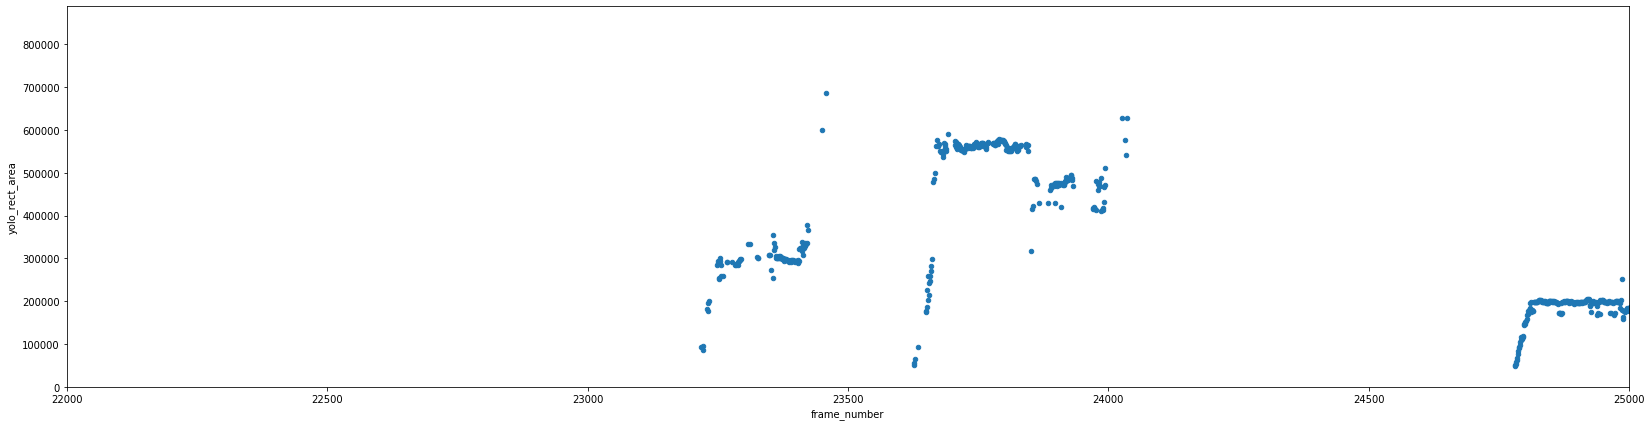

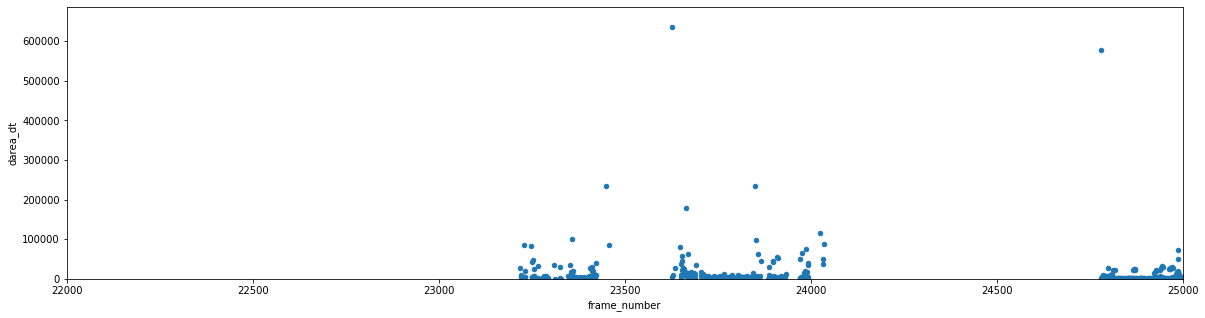

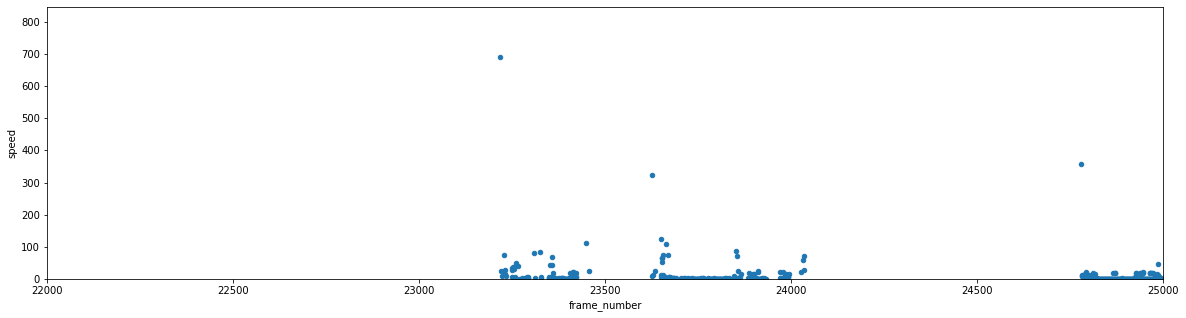

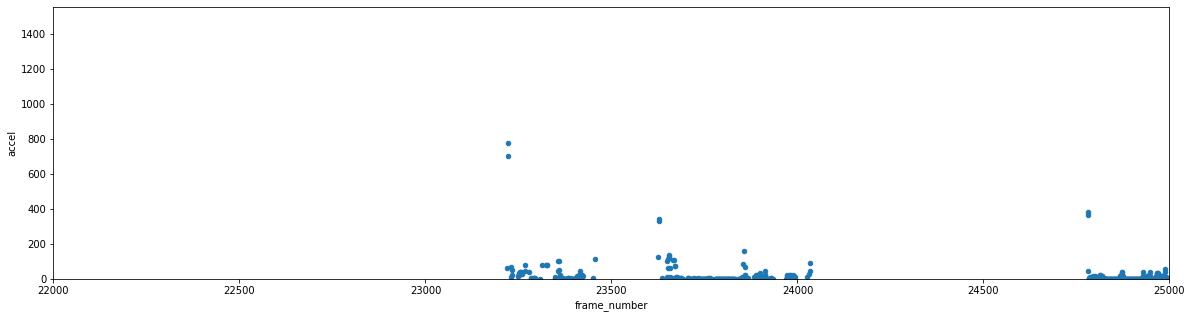

In [103]:
xlim=(22000,25000)
kind = "scatter"
xvar = "frame_number"
base.plot(x=xvar, y="yolo_rect_area", kind=kind, ylim=(0,888906), figsize=(28,7), xlim=xlim) #(0,888906)
base.plot(x=xvar, y="darea_dt", kind=kind, ylim=(0,686351), figsize=(20,5), xlim=xlim)
base.plot(x=xvar, y="speed", kind=kind, ylim=(0,846), figsize=(20,5), xlim=xlim)
base.plot(x=xvar, y="accel", kind=kind, ylim=(0,1555), figsize=(20,5), xlim=xlim)

In [105]:
base_filtrada = base.copy()
base_filtrada = base[(base.yolo_rect_area>140000)]
base_filtrada = base_filtrada[(base_filtrada.accel<9)]
base_filtrada = base_filtrada[(base_filtrada.speed<5)]
#base_filtrada = base_filtrada[(base_filtrada.darea_dt<6000)]

In [106]:
base.head(3)
base_filtrada.head(3)

,Unnamed: 0,frame_number,vehicle_type,yolo_rect_area,yolo_centroid,b_mean,g_mean,r_mean,yolo_confidence,plate,plate_confidence,yolo_centroid_x,yolo_centroid_y,area_per_n,area_per_x,area_per_y,darea_dt,speed,accel
185,185,709,car,145168,"(739.0, 268.0)",118.315882,131.062900,124.096481,0.995981,NaN,NaN,739.0,268.0,204.750353,196.438430,541.671642,919,0.707107,2.0
186,186,710,car,145666,"(738.5, 266.0)",118.999609,131.761907,124.439313,0.995796,NaN,NaN,738.5,266.0,205.163380,197.245768,547.616541,498,2.061553,1.0
187,187,711,car,144900,"(738.0, 265.5)",119.382091,132.193112,124.663720,0.996244,NaN,NaN,738.0,265.5,203.797468,196.341463,545.762712,766,0.707107,2.5


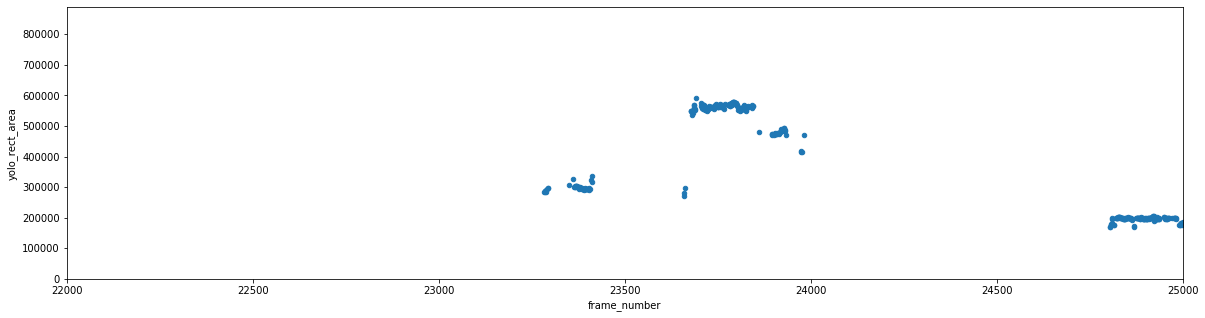

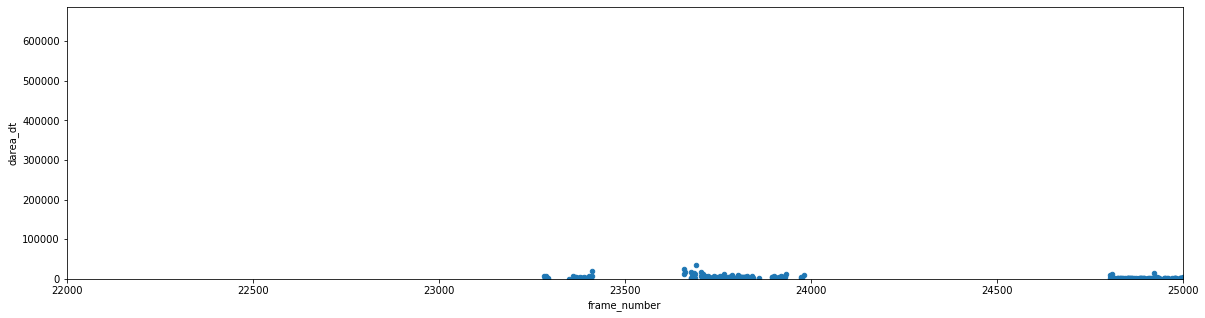

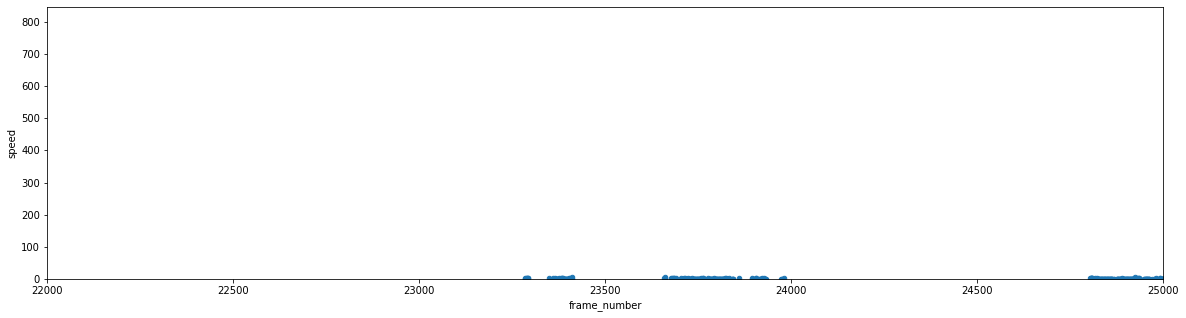

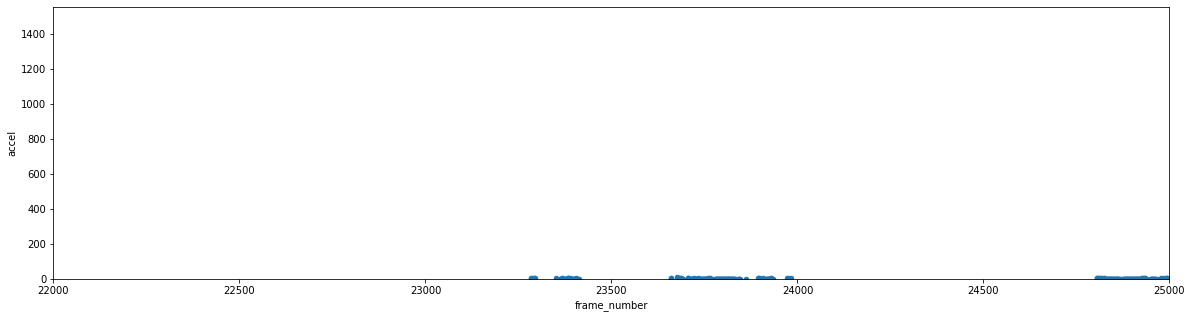

In [107]:
base_filtrada.plot(x=xvar, y="yolo_rect_area", kind=kind, ylim=(0,888906), figsize=(20,5), xlim=xlim)
base_filtrada.plot(x=xvar, y="darea_dt", kind=kind, ylim=(0,686351), figsize=(20,5), xlim=xlim)
base_filtrada.plot(x=xvar, y="speed", kind=kind, figsize=(20,5), ylim=(0,846), xlim=xlim)
base_filtrada.plot(x=xvar, y="accel", kind=kind, ylim=(0,1555), figsize=(20,5), xlim=xlim)

# Cluster

In [11]:
small_base = base_filtrada[base_filtrada["frame_number"].isin(range(0,len(base_filtrada)))]
small_base = small_base[['frame_number', 'yolo_rect_area', 'b_mean', 'g_mean', 
                         'r_mean', 'yolo_centroid_x', 'yolo_centroid_y', 'area_per_n',
                         'area_per_x', 'area_per_y', 'Unnamed: 0', 'darea_dt']]
clustering_variables = ['frame_number', 'b_mean', 'g_mean', 
                         'r_mean', 'yolo_centroid_x', 'yolo_centroid_y', 'area_per_n',
                         'area_per_x', 'area_per_y', 'Unnamed: 0', 'darea_dt']
small_base_X = small_base
small_base_X = small_base_X.to_numpy()

base_filtrada = base.copy()
base_filtrada.loc[base.darea_dt >= 7200, "yolo_rect_area"] = np.nan

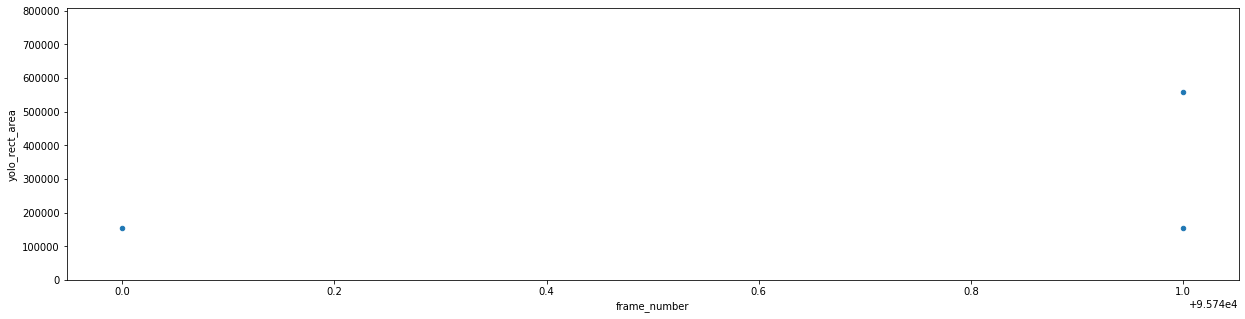

In [13]:
small_base.plot(x="frame_number", y="yolo_rect_area", kind="scatter", ylim=(0,807811), figsize=(21,5))

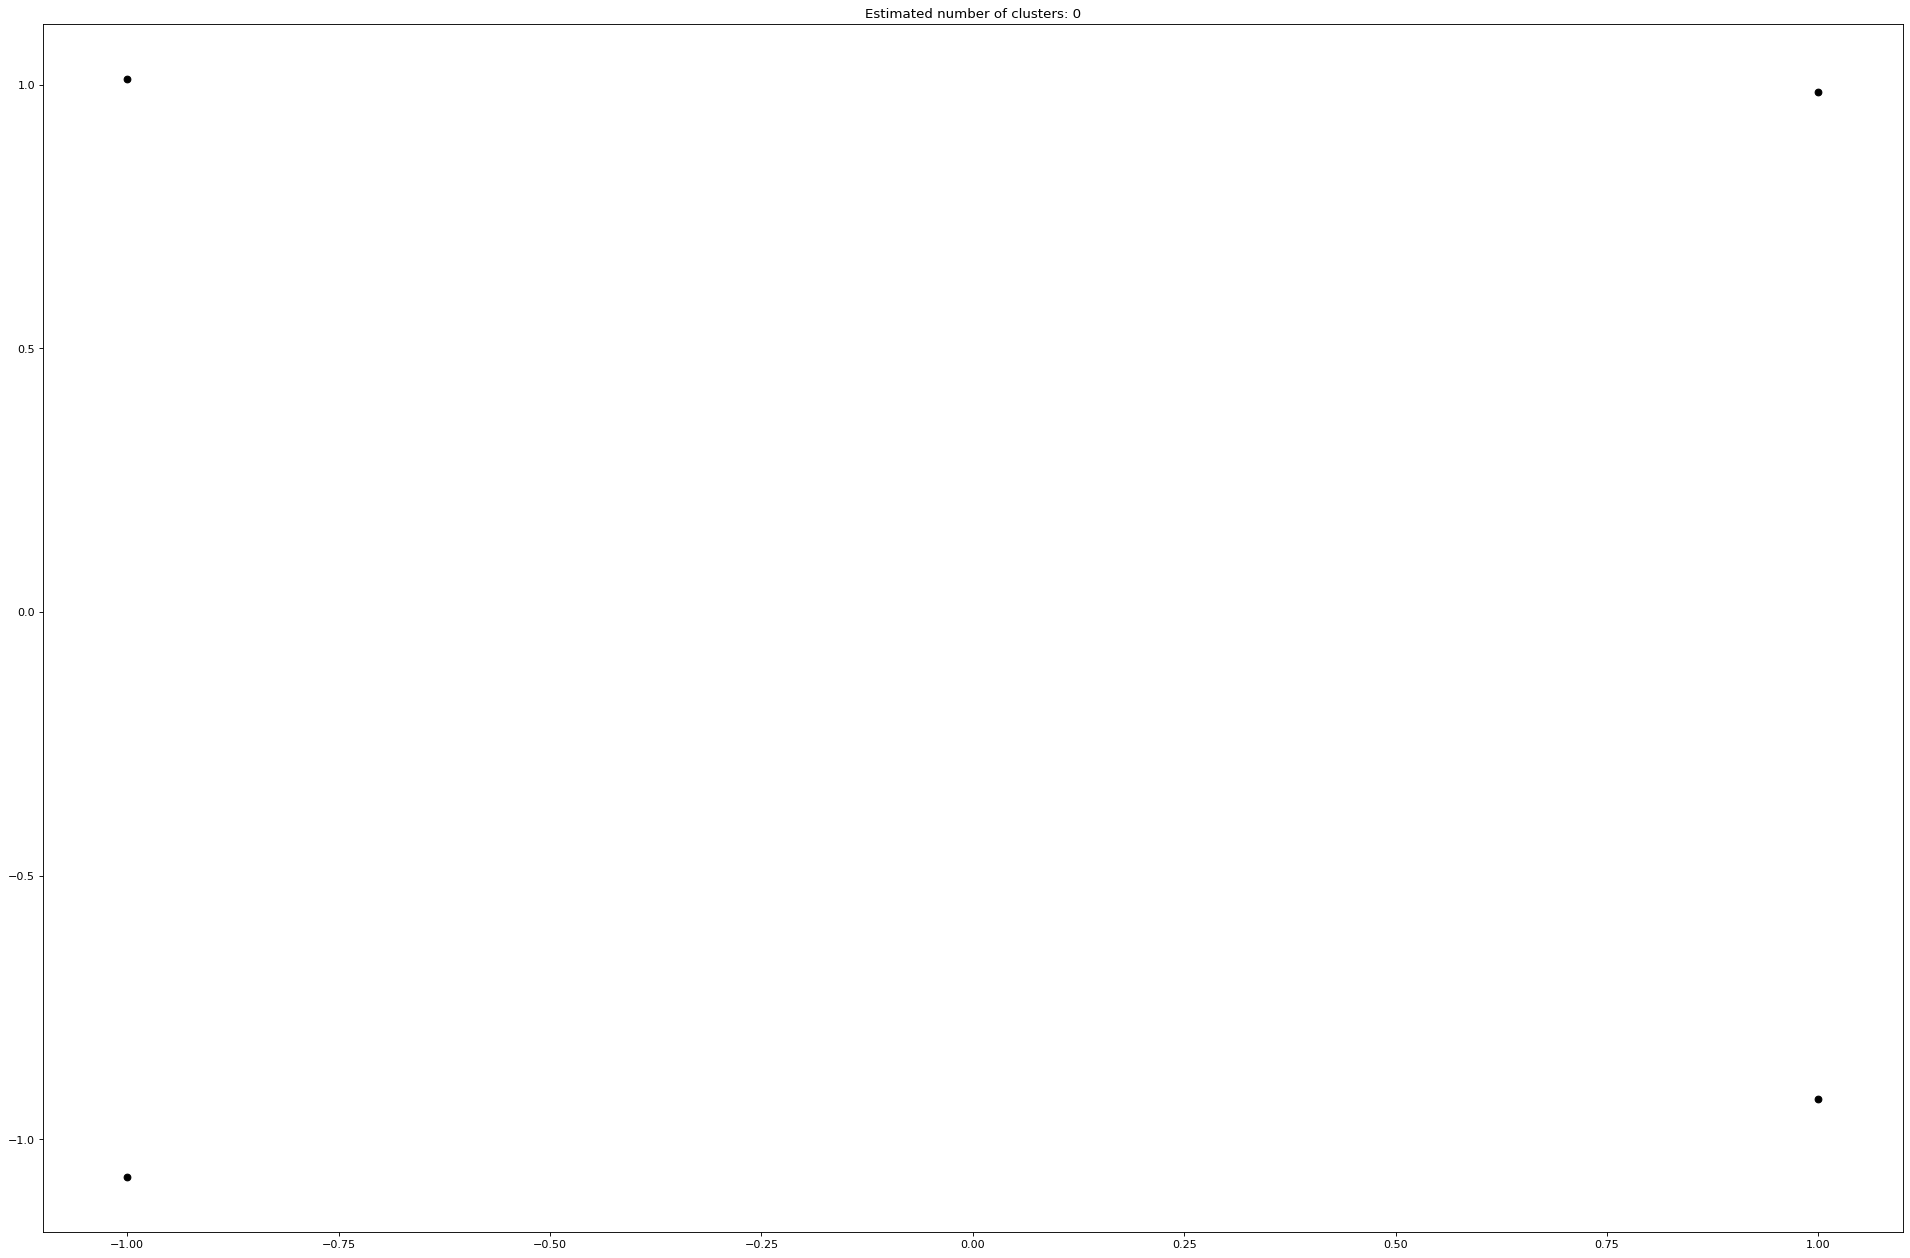

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plot = True

# variables to cluster
X = small_base_X
X = StandardScaler().fit_transform(X)

# dbscan params
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice',
           'euclidean', 'hamming', 'infinity', 'jaccard', 'kulsinski', 
           'l1', 'l2', 'manhattan', 'matching','p', 'rogerstanimoto', 
           'russellrao','sokalmichener', 'sokalsneath']
epss = [ii for ii in np.arange(0.1,1.0,0.1)]
min_sampless = [int(ii) for ii in np.arange(2,50,2)]

metric = metrics[5]
min_samples = min_sampless[20]
eps = epss[4]

# dbscan results dict
db_cluster_results = {"metric":[], "eps":[], "min_samples":[], "n_cats":[], "cats":[]}

# clusterer
db_cluster_results["metric"].append(metric)
db_cluster_results["eps"].append(eps)
db_cluster_results["min_samples"].append(min_samples)
clt = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
clt.fit(X)
labels = clt.labels_
core_samples_mask = np.zeros_like(clt.labels_, dtype=bool)
core_samples_mask[clt.core_sample_indices_] = True
db_cluster_results["cats"].append(labels)
db_cluster_results["n_cats"].append(labels.max())
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

if plot:
    figure(num=None, figsize=(30,20), dpi=80, facecolor='w', edgecolor='k')
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
# select part of the data
plot = False
X = small_base.to_numpy()
X = StandardScaler().fit_transform(X)

metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice',
           'euclidean', 'hamming', 'infinity', 'jaccard', 'kulsinski', 
           'l1', 'l2', 'manhattan', 'matching','p', 'rogerstanimoto', 
           'russellrao','sokalmichener', 'sokalsneath']
epss = [ii for ii in np.arange(0.1,1.0,0.1)]
min_sampless = [int(ii) for ii in np.arange(2,50,2)]

db_cluster_results = {"metric":[], "eps":[], "min_samples":[], "n_cats":[], "cats":[]}

for metric, eps, min_samples in itertools.product(metrics, epss, min_sampless):
    db_cluster_results["metric"].append(metric)
    db_cluster_results["eps"].append(eps)
    db_cluster_results["min_samples"].append(min_samples)
    clt = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    clt.fit(X)
    labels = clt.labels_
    core_samples_mask = np.zeros_like(clt.labels_, dtype=bool)
    core_samples_mask[clt.core_sample_indices_] = True
    db_cluster_results["cats"].append(labels)
    db_cluster_results["n_cats"].append(labels.max())
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    if plot:
        small_base["label"] = labels
        small_base.plot(x="frame_number", y="frame_number", c="label", 
                        kind="scatter", figsize=(21,7), colormap="Accent")

KeyboardInterrupt: 

## hdbscan

In [ ]:
import hdbscan
from sklearn.preprocessing import StandardScaler
# select part of the data
plot = True
X = small_base.to_numpy()
X = StandardScaler().fit_transform(X)

metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice',
           'euclidean', 'hamming', 'infinity', 'jaccard', 'kulsinski', 
           'l1', 'l2', 'manhattan', 'matching','p', 'rogerstanimoto', 
           'russellrao','sokalmichener', 'sokalsneath']
min_cluster_sizes = [int(ii) for ii in list(np.arange(10,50,2))]

hdb_cluster_results = {"metric":[], "min_cluster_size":[], "n_cats":[], "cats":[]}
for metric, min_cluster_size in itertools.product(metrics,min_cluster_sizes):
    hdb_cluster_results["metric"].append(metric)
    hdb_cluster_results["min_cluster_size"].append(min_cluster_size)
    
    clt = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric=metric, 
                          core_dist_n_jobs=-1)
    clt.fit(X)
    labels = clt.labels_
    
    hdb_cluster_results["cats"].append(labels)
    hdb_cluster_results["n_cats"].append(labels.max())
    if plot:
        small_base["label"] = clt.labels_
        small_base.plot(x="frame_number", y="frame_number", c="label", 
                        kind="scatter", figsize=(21,7), colormap="Accent")

## dbscan

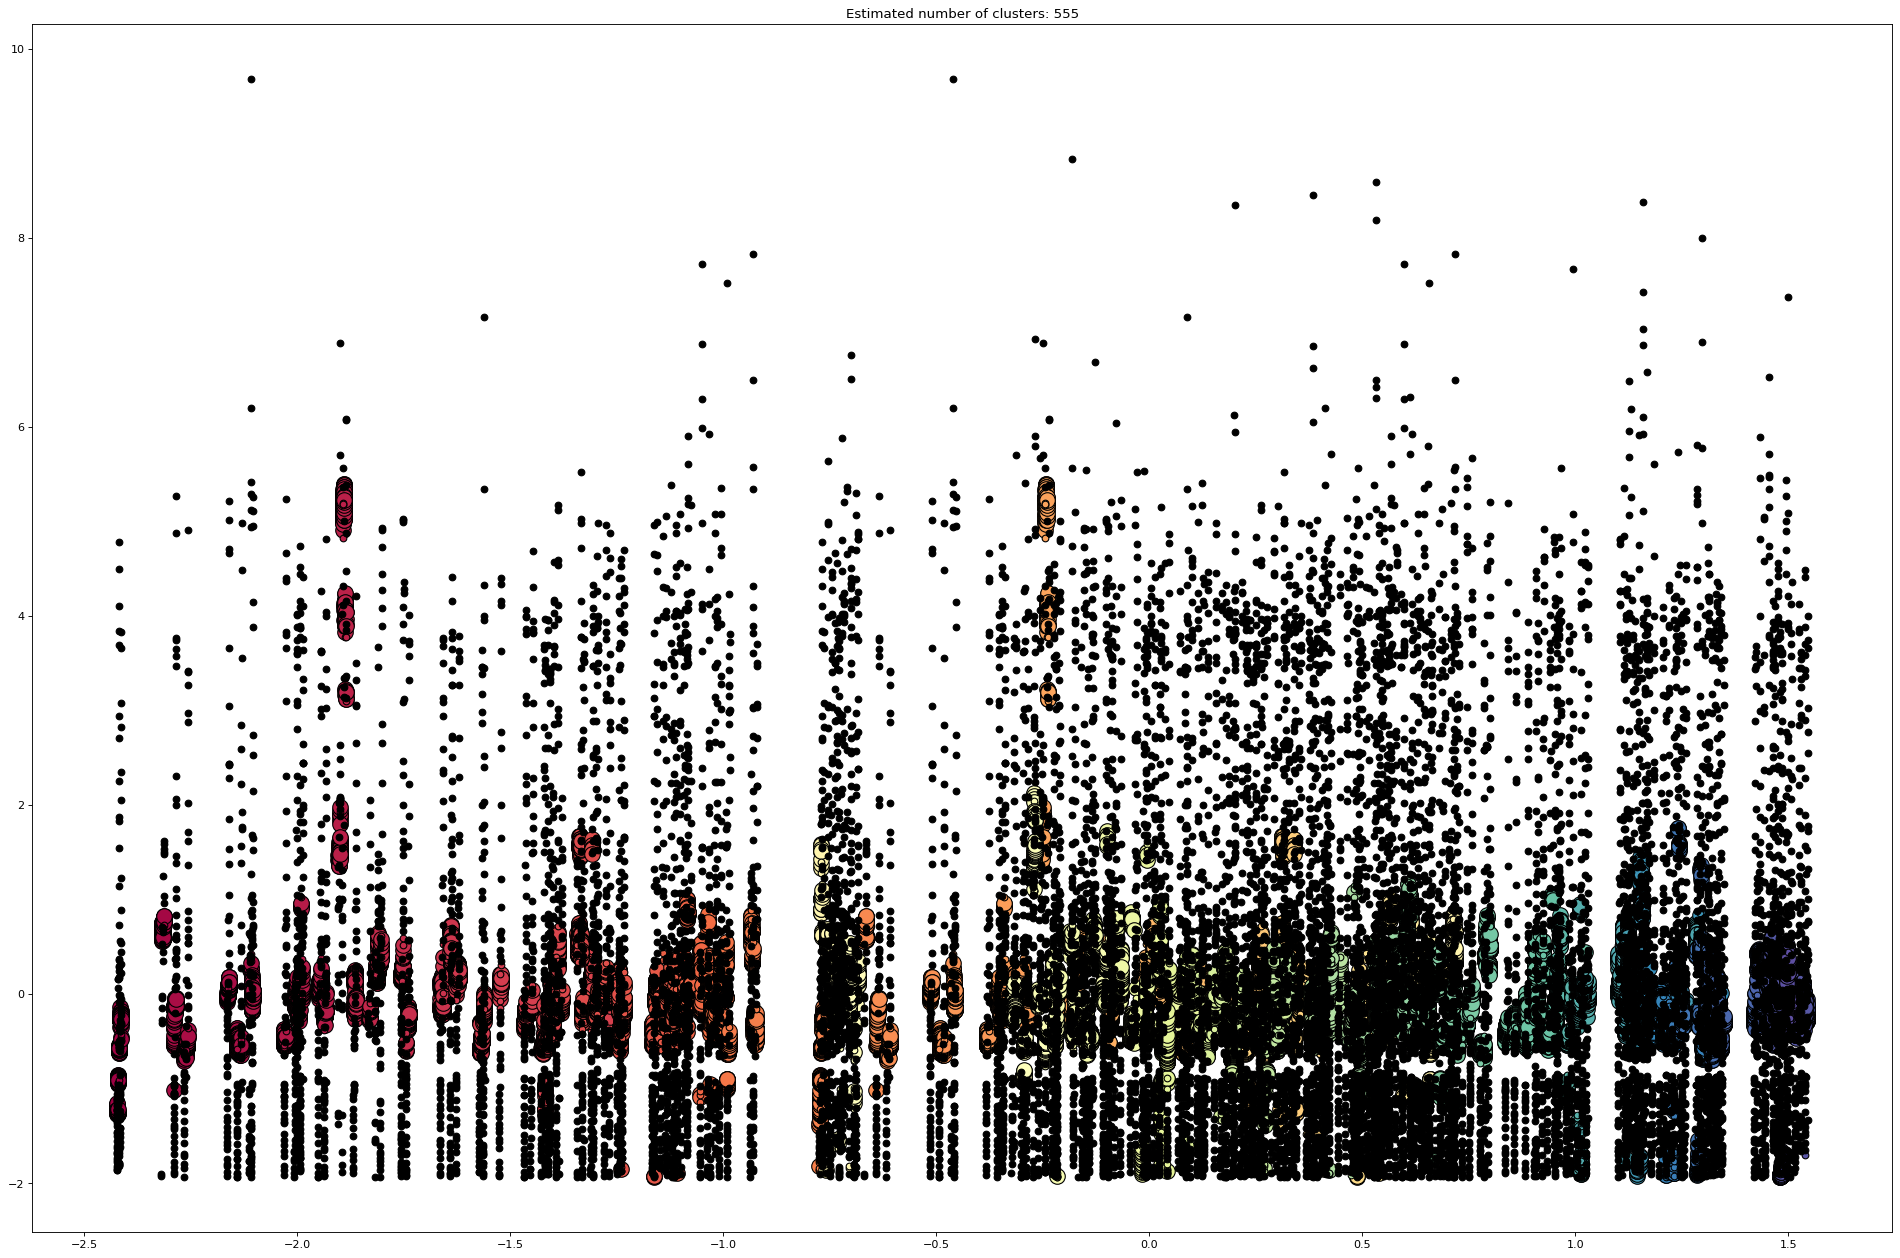

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(30,20), dpi=80, facecolor='w', edgecolor='k')
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()